In [1]:
%pylab inline
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from ipdb import set_trace
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaGAN import *
from utils import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
gpu = True
workers = 4
LAMBDA= 10
_eps = 1e-15
device = torch.device('cuda:2')

Use_BRATS = False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

In [3]:
trainset = ADNIdataset(augmentation=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)

if Use_BRATS:
    #imgtype -> 'flair' or 't2' or 't1ce'
    trainset = BRATSdataset(train=True, imgtype = 'flair',augmentation=False)
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
if Use_ATLAS:
    trainset = ATLASdataset(augmentation=True)
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)

In [4]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

In [5]:
G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
E = Discriminator(out_class = latent_dim ,is_dis=False)

G.to(device)
D.to(device)
CD.to(device)
E.to(device)


Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
)

In [6]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

In [7]:
def calc_gradient_penalty(model, x, x_gen, w=10):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_()
    x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = Variable(x_hat, requires_grad=True)

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2

    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

# Training

In [8]:
real_y = Variable(torch.ones((BATCH_SIZE, 1)).to(device=device))
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).to(device=device))

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

# load the highest savepoints of all models
iteration = load_checkpoint(G, D, E, CD, '_noW_iter')
df = load_loss()
# iteration = 0

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: volatile w

[0/200000] D: 3.26     En_Ge: 9.55     Code: 1.41    


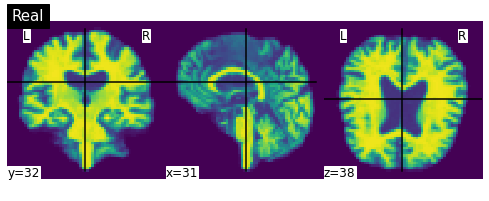

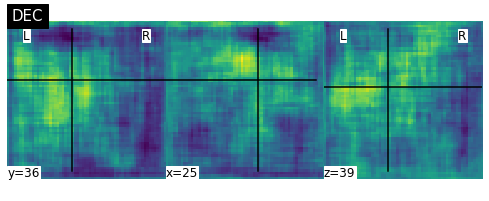

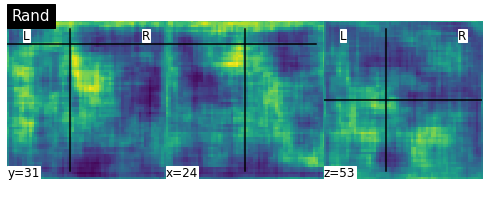

[100/200000] D: 1.09     En_Ge: 8.31     Code: 1.54    


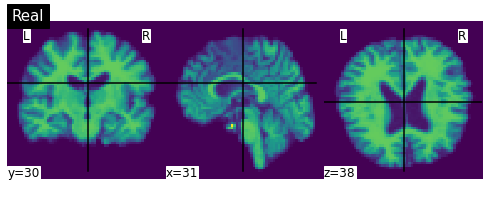

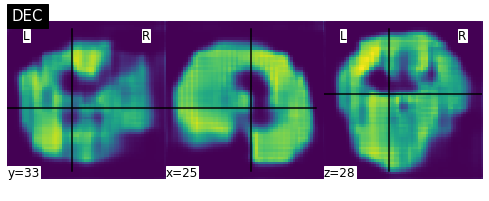

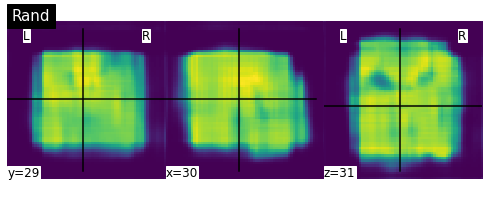

[200/200000] D: 1.47     En_Ge: 10.4     Code: 1.41    


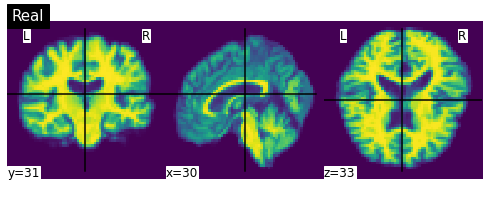

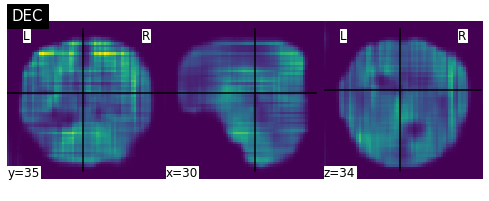

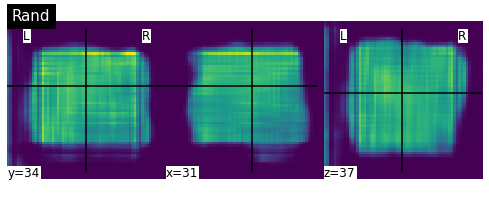

[300/200000] D: 0.667    En_Ge: 12.8     Code: 1.39    


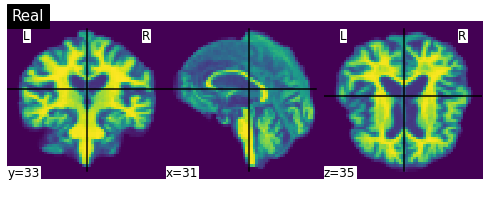

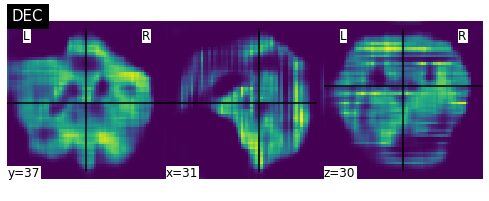

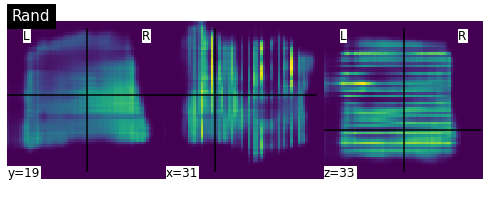

[400/200000] D: 1.87     En_Ge: 8.53     Code: 1.39    


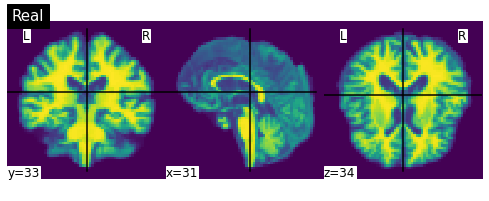

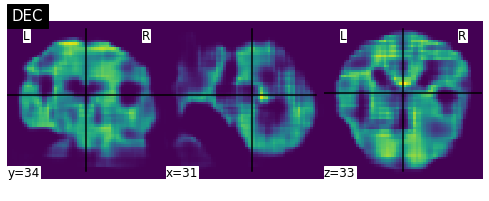

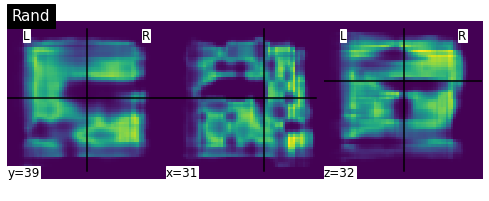

[500/200000] D: 0.405    En_Ge: 13.5     Code: 1.39    


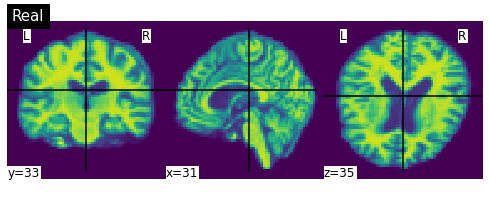

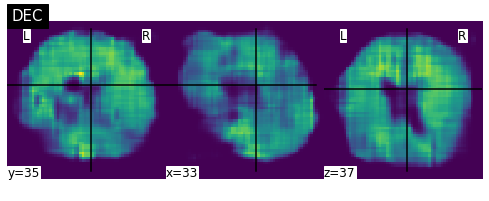

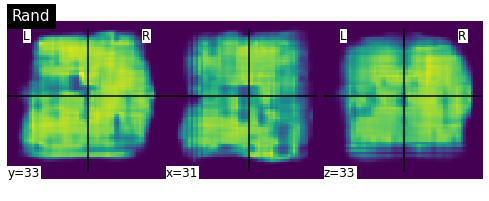

[600/200000] D: 2.43     En_Ge: 4.84     Code: 1.39    


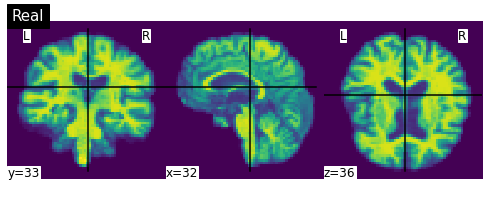

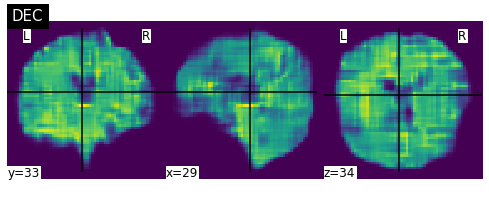

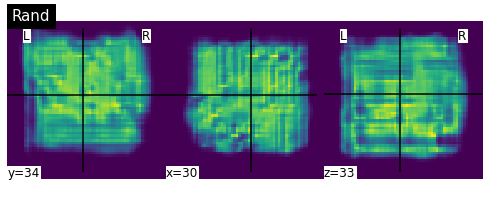

[700/200000] D: 2.02     En_Ge: 14.1     Code: 1.38    


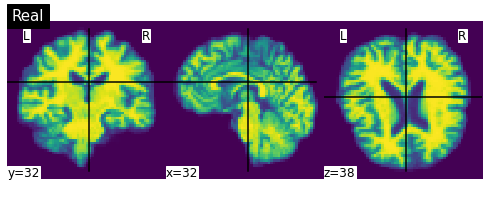

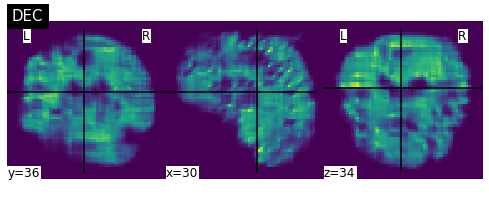

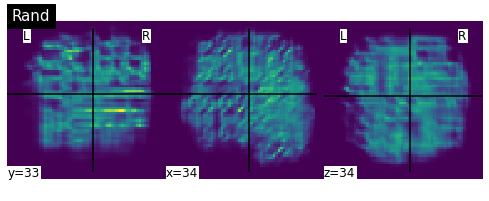

[800/200000] D: 1.49     En_Ge: 9.38     Code: 1.39    


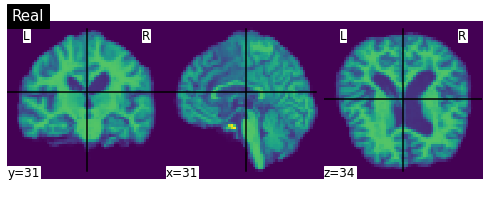

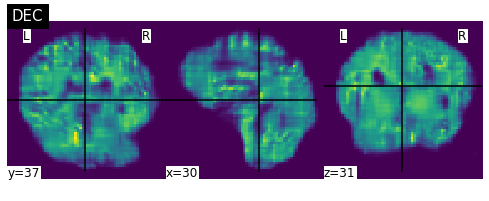

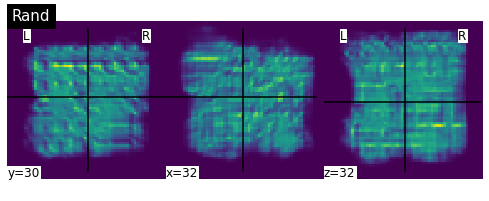

[900/200000] D: 0.851    En_Ge: 9.34     Code: 1.39    


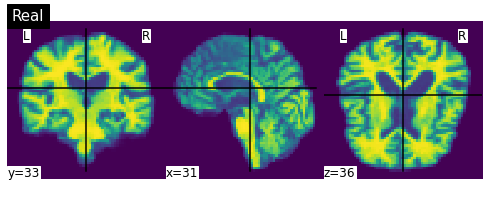

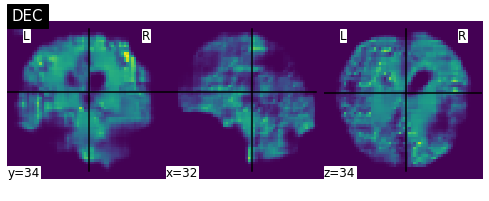

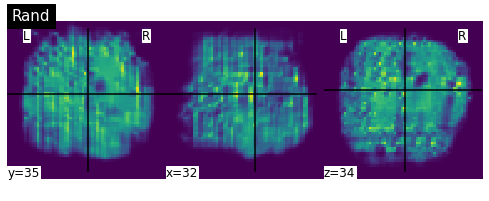

currrent iteration: 999
[1000/200000] D: 2.23     En_Ge: 5.64     Code: 1.38    


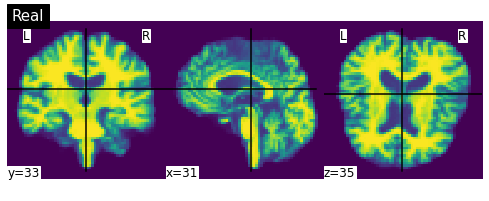

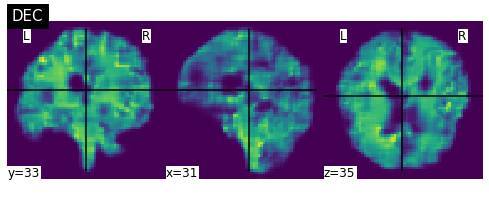

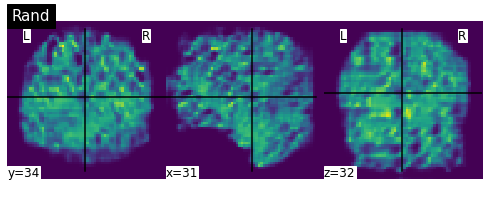

[1100/200000] D: 0.966    En_Ge: 9.91     Code: 1.38    


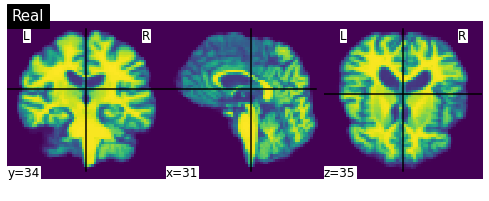

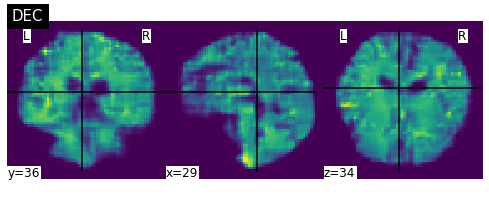

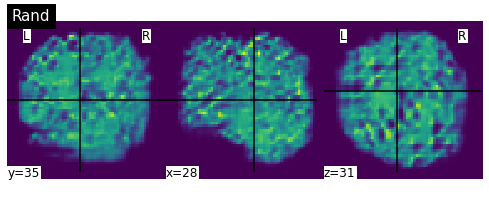

In [ ]:
gen_load = inf_train_gen(train_loader)
MAX_ITER = 200000
while iteration < MAX_ITER:
    ###############################################
    # Train Encoder - Generator 
    ###############################################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = False
    for p in CD.parameters():  # reset requires_grad
        p.requires_grad = False
    for p in E.parameters():  # reset requires_grad
        p.requires_grad = True
    for p in G.parameters():  # reset requires_grad
        p.requires_grad = True

    g_optimizer.zero_grad()
    e_optimizer.zero_grad()


    for iters in range(1):
        real_images = gen_load.__next__()
        real_images = Variable(real_images,volatile=True).to(device=device)
        _batch_size = real_images.size(0)
        z_hat = E(real_images).view(_batch_size,-1)
        z_rand = Variable(torch.randn((_batch_size,latent_dim)),requires_grad=False).to(device=device)

        x_hat = G(z_hat)
        x_rand = G(z_rand)

        l1_loss = 10 * criterion_l1(x_hat, real_images)
        c_loss = criterion_bce(CD(z_hat), real_y[:_batch_size])
        d_real_loss = criterion_bce(D(x_hat), real_y[:_batch_size]) 
        d_fake_loss = criterion_bce(D(x_rand), real_y[:_batch_size])

        loss1 = l1_loss + c_loss + d_real_loss + d_fake_loss

        loss1.backward(retain_graph=True)
        e_optimizer.step()

        g_optimizer.step()
        g_optimizer.step()

    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for iters in range(1):
        d_optimizer.zero_grad()

        z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).to(device=device)
        z_hat = E(real_images).view(_batch_size,-1)
        x_hat = G(z_hat)
        x_rand = G(z_rand)

        x_loss2 = 2.0 * criterion_bce(D(real_images), real_y[:_batch_size])+criterion_bce(D(x_hat), fake_y[:_batch_size])
        z_loss2 = criterion_bce(D(x_rand), fake_y[:_batch_size])
        loss2 = x_loss2 + z_loss2

        if iters<4:
            loss2.backward(retain_graph=True)
        else:
            loss2.backward(retain_graph=True)
        d_optimizer.step()
    ###############################################
    # Train CD
    ###############################################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = False
    for p in CD.parameters():  # reset requires_grad
        p.requires_grad = True
    for p in E.parameters():  # reset requires_grad
        p.requires_grad = False
    for p in G.parameters():  # reset requires_grad
        p.requires_grad = False

    for iters in range(1):
        cd_optimizer.zero_grad()
        z_hat = E(real_images).view(_batch_size,-1)
        x_loss3 = criterion_bce(CD(z_hat), fake_y[:_batch_size])
        z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).to(device=device)
        z_loss3 = criterion_bce(CD(z_rand), real_y[:_batch_size])
        loss3 = x_loss3 + z_loss3
        loss3.backward(retain_graph=True)
        cd_optimizer.step()
        
    ###############################################
    # Visualization
    ###############################################

    if iteration % 100 == 0:
        print('[{}/{}]'.format(iteration,MAX_ITER),
              'D: {:<8.3}'.format(loss2.item()), 
              'En_Ge: {:<8.3}'.format(loss1.item()),
              'Code: {:<8.3}'.format(loss3.item()))

        featmask = np.squeeze((0.5*real_images[0]+0.5).data.cpu().numpy())
        featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
        plotting.plot_img(featmask,title="Real")
        plotting.show()

        featmask = np.squeeze((0.5*x_hat[0]+0.5).data.cpu().numpy())
        featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
        plotting.plot_img(featmask,title="DEC")
        plotting.show()

        featmask = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
        plotting.plot_img(featmask,title="Rand")
        plotting.show()

    if (iteration+1)%1000 == 0: 
        print(f'currrent iteration: {iteration}')
        torch.save(G.state_dict(),'./checkpoint/G_noW_iter'+str(iteration+1)+'.pth')
        torch.save(D.state_dict(),'./checkpoint/D_noW_iter'+str(iteration+1)+'.pth')
        torch.save(E.state_dict(),'./checkpoint/E_noW_iter'+str(iteration+1)+'.pth')
        torch.save(CD.state_dict(),'./checkpoint/CD_noW_iter'+str(iteration+1)+'.pth')
        df = add_loss(df, iteration, loss1.item())
        write_loss(df)
        
    iteration += 1
